#### Data import

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import numpy as np
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.svm import LinearSVC
import time

In [4]:
data = pd.read_csv("fraud_detection.csv")

In [5]:
data.head()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
1,3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
2,251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0
3,252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0
4,680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0


#### Data vizualization

In the dataset we have 2 variables, which describe the fraud occurence: isFraud and isFlaggedFraud. I have a believe that 
isFraud = isFlaggedFraud. So I will plot them according to number of fraud transaction. I would also like to investiate which types of transactions ar likely to be fraud.  

Text(0, 0.5, 'Count of transaction')

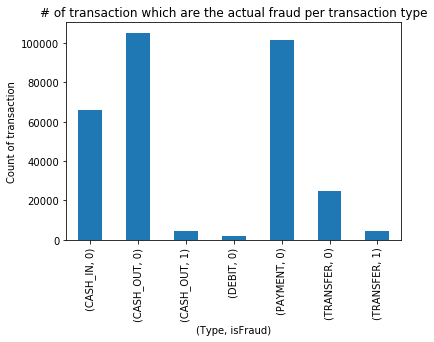

In [6]:
ax = data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which are the actual fraud per transaction type")
ax.set_xlabel("(Type, isFraud)")
ax.set_ylabel("Count of transaction")

We can see on the plot that only cash_out and transfer have fraud transactions. 

Text(0, 0.5, 'Count of transaction')

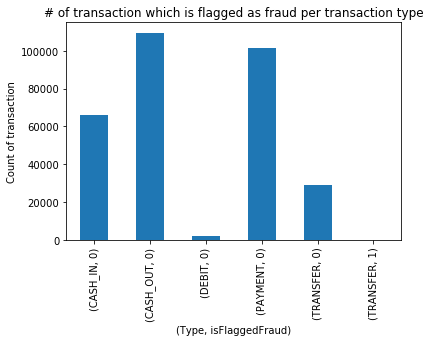

In [7]:
ax = data.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title("# of transaction which is flagged as fraud per transaction type")
ax.set_xlabel("(Type, isFlaggedFraud)")
ax.set_ylabel("Count of transaction")

We can see that only transfer have fraud transaction. 

##### IsFraud != isFlaggedFraud. isFlaggedFraud variable does not explain the fraud accurance at all; so it is insignificant variable. 

### Data preparation

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308213 entries, 0 to 308212
Data columns (total 12 columns):
Unnamed: 0        308213 non-null int64
step              308213 non-null int64
type              308213 non-null object
amount            308213 non-null float64
nameOrig          308213 non-null object
oldbalanceOrg     308213 non-null float64
newbalanceOrig    308213 non-null float64
nameDest          308213 non-null object
oldbalanceDest    308213 non-null float64
newbalanceDest    308213 non-null float64
isFraud           308213 non-null int64
isFlaggedFraud    308213 non-null int64
dtypes: float64(5), int64(4), object(3)
memory usage: 28.2+ MB


Preparation before choosing chategorical values.

In [9]:
type_num = len(data['type'].unique().tolist())
print("Number of unique variables in 'type' : {} ".format(type_num))

Number of unique variables in 'type' : 5 


In [10]:
type_num = len(data['nameDest'].unique().tolist())
print("Number of unique variables in 'type' : {} ".format(type_num))

Number of unique variables in 'type' : 254139 


In [11]:
type_num = len(data['nameOrig'].unique().tolist())
print("Number of unique variables in 'type' : {} ".format(type_num))

Number of unique variables in 'type' : 307785 


##### So 'nameDest' and  'nameOrig' have a lot of unique variables and can not be transfered to chategorical variables. Unless the variable 'type'.

Check for missing values

In [12]:
data.isnull().sum()

Unnamed: 0        0
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

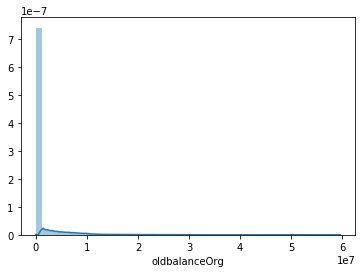

In [13]:
sns.distplot(data['oldbalanceOrg']);

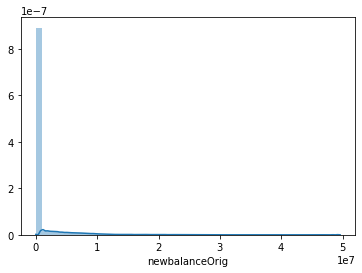

In [14]:
sns.distplot(data['newbalanceOrig']);

We can see that a lot of transactins have old and new balance staying zero, even though the non zero amount was transfered. The solution is to create new variable, which will compure this error.

In [15]:
data['errorBalanceOrig'] = data.newbalanceOrig + data.amount - data.oldbalanceOrg
data['errorBalanceDest'] = data.oldbalanceDest + data.amount - data.newbalanceDest

In [16]:
data.head()

,Unnamed: 0,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
0,2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0,0.0,181.0
1,3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0,0.0,21363.0
2,251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,0,0.0,2806.0
3,252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,0,0.0,29008.0
4,680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,0,0.0,20128.0


Find correlated variables

In [17]:
data.corr()

,Unnamed: 0,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
Unnamed: 0,1.000000,0.961922,0.050819,-0.000197,-0.009238,0.029044,0.030765,0.094834,0.009717,0.019395,0.040088
step,0.961922,1.000000,0.061321,-0.000741,-0.013866,0.023143,0.025892,0.141423,0.014336,0.012925,0.050573
amount,0.050819,0.061321,1.000000,0.098006,0.003156,0.239750,0.408346,0.280715,0.045635,0.774128,0.099724
oldbalanceOrg,-0.000197,-0.000741,0.098006,1.000000,0.986572,0.061556,0.045440,0.045421,0.017188,0.048225,0.199995
newbalanceOrig,-0.009238,-0.013866,0.003156,0.986572,1.000000,0.066241,0.038671,-0.037883,0.017263,0.059389,0.146079
oldbalanceDest,0.029044,0.023143,0.239750,0.061556,0.066241,1.000000,0.971511,-0.027753,-0.002386,0.315133,-0.049136
newbalanceDest,0.030765,0.025892,0.408346,0.045440,0.038671,0.971511,1.000000,0.001695,-0.002468,0.467399,-0.179130
isFraud,0.094834,0.141423,0.280715,0.045421,-0.037883,-0.027753,0.001695,1.000000,0.043774,-0.051189,0.196005
isFlaggedFraud,0.009717,0.014336,0.045635,0.017188,0.017263,-0.002386,-0.002468,0.043774,1.000000,0.056074,0.062202
errorBalanceOrig,0.019395,0.012925,0.774128,0.048225,0.059389,0.315133,0.467399,-0.051189,0.056074,1.000000,-0.134844


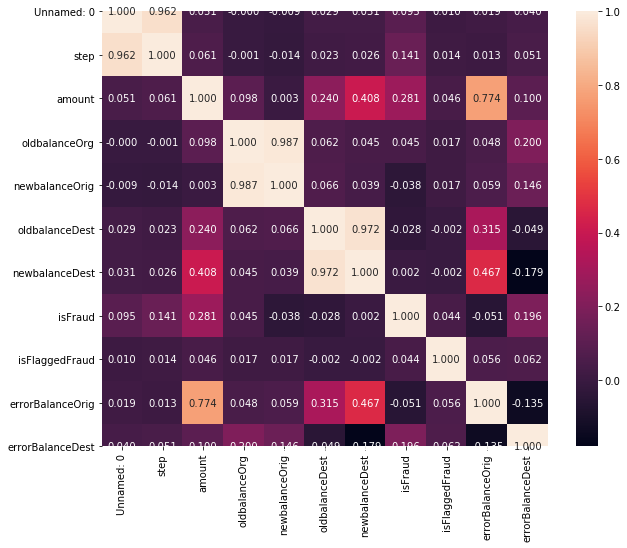

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot = True, fmt = '.3f')

We have found correlated variables, so they need to be droped

In [19]:
data = data.drop(['oldbalanceDest','oldbalanceOrg', 'isFlaggedFraud'],axis = 1)

In [20]:
data.shape

(308213, 11)

In [21]:
df = pd.get_dummies(data['type'], drop_first=True)

In [22]:
data = pd.concat([data,df],axis=1)

In [23]:
data.drop(labels = ['type','nameOrig','nameDest','DEBIT','PAYMENT'], axis=1,inplace=True)

In [24]:
data.head()

,Unnamed: 0,step,amount,newbalanceOrig,newbalanceDest,isFraud,errorBalanceOrig,errorBalanceDest,CASH_OUT,TRANSFER
0,2,1,181.0,0.0,0.0,1,0.0,181.0,0,1
1,3,1,181.0,0.0,0.0,1,0.0,21363.0,1,0
2,251,1,2806.0,0.0,0.0,1,0.0,2806.0,0,1
3,252,1,2806.0,0.0,0.0,1,0.0,29008.0,1,0
4,680,1,20128.0,0.0,0.0,1,0.0,20128.0,0,1


In [25]:
data.shape

(308213, 10)

### Dealing with imbalance data. Over and Under-sampling 

In [26]:
is_Fraud = data.loc[data['isFraud']==1]
not_Fraud = data.loc[data['isFraud']==0]
normal_distributed_df = pd.concat([is_Fraud, not_Fraud])
new_df = normal_distributed_df.sample(frac=1, random_state=42)

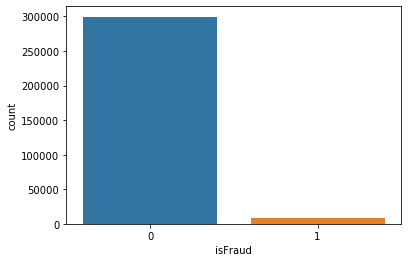

In [27]:
sns.countplot("isFraud", data=new_df).set_title("");

We can see that data is highly unbalance. Lets see how this will reflect on model accuracies

In [28]:
X = data.drop('isFraud', axis=1)
y = data['isFraud']

In [29]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [51]:
model = LogisticRegression(solver='lbfgs', max_iter = 1000)
time1 =time.time()
model.fit(x_train, y_train)
time2 = time.time()
print(time2-time1)

11.857204675674438


In [31]:
print("Training accuracy: {}".format(model.score(x_train, y_train)))

predicted_1 = model.predict(x_test)

print("Testing accuracy:  {}".format(metrics.accuracy_score(y_test, predicted_1)))

Training accuracy: 0.9832786123136822
Testing accuracy:  0.9828140515775088


In [32]:
print(classification_report(y_test, predicted_1)) 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     98888
           1       0.70      0.66      0.68      2823

    accuracy                           0.98    101711
   macro avg       0.85      0.83      0.84    101711
weighted avg       0.98      0.98      0.98    101711



### Overfitting

In [33]:
y_train.value_counts()

0    200701
1      5801
Name: isFraud, dtype: int64

In [34]:
smt = SMOTE()
x_train_over, y_train_over = smt.fit_sample(x_train, y_train)

In [35]:
np.bincount(y_train_over)

array([200701, 200701])

In [52]:
model1 = LogisticRegression(solver='lbfgs', max_iter = 1000)
time1 =time.time()
model1.fit(x_train_over, y_train_over)
time2 = time.time()
print(time2-time1)

16.10359263420105


In [37]:
print("Training accuracy: {}".format(model1.score(x_train_over, y_train_over)))

predicted_2 = model1.predict(x_test)

print("Testing accuracy:  {}".format(metrics.accuracy_score(y_test, predicted_2)))

Training accuracy: 0.9136277347895626
Testing accuracy:  0.9219553440630807


In [38]:
print(classification_report(y_test, predicted_2)) 

              precision    recall  f1-score   support

           0       1.00      0.92      0.96     98888
           1       0.25      0.90      0.39      2823

    accuracy                           0.92    101711
   macro avg       0.62      0.91      0.67    101711
weighted avg       0.98      0.92      0.94    101711



### Underfitting

In [39]:
nr = NearMiss()
x_train_under, y_train_under = nr.fit_sample(x_train, y_train)

In [38]:
np.bincount(y_train_under)

array([5801, 5801])

In [53]:
model2 = LogisticRegression(solver='lbfgs', max_iter = 1000)
time1 = time.time()
model2.fit(x_train_under, y_train_under)
time2 = time.time()
print(time2-time1)

10.163719892501831


In [40]:
print("Training accuracy: {}".format(model2.score(x_train_under, y_train_under)))

predicted_3 = model2.predict(x_test)

print("Testing accuracy:  {}".format(metrics.accuracy_score(y_test, predicted_3)))

Training accuracy: 0.9325116359248405
Testing accuracy:  0.3404253227281218


In [41]:
print(classification_report(y_test, predicted_3)) 

              precision    recall  f1-score   support

           0       0.99      0.32      0.49     98888
           1       0.04      0.94      0.07      2823

    accuracy                           0.34    101711
   macro avg       0.52      0.63      0.28    101711
weighted avg       0.97      0.34      0.48    101711



The model has high recall for major Class, but very small for minor. Sp the fraud detection will not work well

The model has much higher recall for minor Class, but smaller for major. The results are pretty good. 

The model has higher recall for minor Class, but very small for major. So we will return to the previous model

### Decision tree

In [54]:
classifier = DecisionTreeClassifier(random_state = 0,
                                    criterion = 'gini',  splitter='best', min_samples_leaf=1, min_samples_split=2)
time1 = time.time()
classifier.fit(x_train_over, y_train_over)
time2 = time.time()
print(time2-time1)
y_pred1 = classifier.predict(x_test)


1.911684274673462


In [41]:
print("Training accuracy: {}".format(classifier.score(x_train_under, y_train_under)))

print("Testing accuracy:  {}".format(metrics.accuracy_score(y_test, y_pred1)))

Training accuracy: 1.0
Testing accuracy:  0.9991741306250062


In [34]:
print(classification_report(y_test, y_pred1)) 


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     98888
           1       0.97      1.00      0.98      2823

    accuracy                           1.00    101711
   macro avg       0.99      1.00      0.99    101711
weighted avg       1.00      1.00      1.00    101711



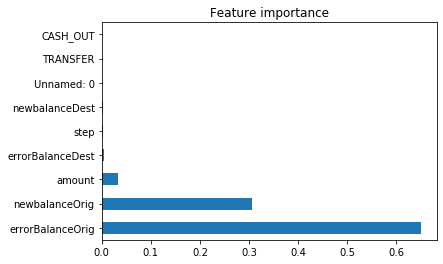

In [35]:
feat_importances = pd.Series(classifier.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh')
plt.title("Feature importance")
plt.show()

In [36]:
print(feat_importances)

Unnamed: 0          0.001028
step                0.002354
amount              0.033317
newbalanceOrig      0.305361
newbalanceDest      0.001908
errorBalanceOrig    0.649279
errorBalanceDest    0.005181
CASH_OUT            0.000570
TRANSFER            0.001002
dtype: float64


### Neural technique

In [51]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units =11 , kernel_initializer = 'uniform', activation = 'relu', input_dim = 11))
# Adding the second hidden layer
classifier.add(Dense(units = 11, kernel_initializer = 'uniform', activation = 'relu'))
# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
classifier.fit(x_train_over, y_train_over, batch_size = 32, epochs = 4)

Epoch 1/4
401402/401402 [==============================] - 48s 120us/step - loss: 0.6046 - accuracy: 0.8771
Epoch 2/4
401402/401402 [==============================] - 43s 106us/step - loss: 0.2909 - accuracy: 0.9102
Epoch 3/4
401402/401402 [==============================] - 45s 111us/step - loss: 0.3668 - accuracy: 0.8639
Epoch 4/4
401402/401402 [==============================] - 42s 105us/step - loss: 0.2833 - accuracy: 0.9351


### Support vactor machine

In [43]:
svc = LinearSVC()

In [55]:
time1 = time.time()
svc.fit(x_train_over, y_train_over)
time2 = time.time()
print(time2-time1)

89.1942834854126


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [45]:
y_pred = svc.predict(x_test)

In [46]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     98888
           1       0.46      0.85      0.59      2823

    accuracy                           0.97    101711
   macro avg       0.73      0.91      0.79    101711
weighted avg       0.98      0.97      0.97    101711



In [47]:
print("Training accuracy: {}".format(svc.score(x_train_under, y_train_under)))

print("Testing accuracy:  {}".format(metrics.accuracy_score(y_test, y_pred)))

Training accuracy: 0.9082916738493363
Testing accuracy:  0.9679484028276194
